# Android Data from PlayStore

In [74]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
# load data
%run ./Preprocessing.ipynb
df = get_data()
orig_df = df.copy()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
name               10841 non-null object
category           10841 non-null object
rating             9367 non-null float64
reviews            10841 non-null object
size               10841 non-null object
installs           10841 non-null object
type               10840 non-null object
price              10841 non-null object
content_rating     10840 non-null object
genres             10841 non-null object
last_updated       10841 non-null object
version            10833 non-null object
android_version    10838 non-null object
dtypes: float64(1), object(12)
memory usage: 1.1+ MB
Number of duplicate entries : 1181
Original values : ['Free' 'Paid' nan]
Unique genres before preprocessing : 118
 Apps with more than one genre : 393 
Unique genres : 48
Oldest updated app : 2010
Longest app name with 25 words : 591 housing transactions - renting houses, middle-class houses, new cases, 

# Science

We transformed the problem in a classification one. Now rating can be *poor* (< 4) and *excellent* (>=4). 

We achieved the following : 
- 70% with RandomForest(n_estimators = 100)

Notes : 
- RandomForest clearly tends to overfit. Reducing the complexity of the tree algorithm doesn't improve accuracy in cross validation by no means. 
    + this may mean that the model is too complex. reducing the number of features took into account can help
**Next thing** : We should try adding or changing the features of data, and try more values for the hyperparameters of the algorithm

In [194]:
df = orig_df.copy()

In [188]:
features = df.columns.values
features

array(['category', 'rating', 'reviews', 'size', 'installs', 'type',
       'price', 'content_rating', 'genres', 'version', 'android_version',
       'price_rounded', 'last_updated_days', 'last_updated_year',
       'last_updated_day', 'last_updated_month_sin',
       'last_updated_month_cos', 'name_wc'], dtype=object)

In [189]:
pre_features = ['category', 'size', 'type', 'price', 'content_rating', 'genres', 'android_version', 'name_wc']
post_features = [feature for feature in df.columns.values if feature not in pre_features]
log_features = ['reviews', 'installs', 'size']

In [190]:
df[log_features] = np.log(df[log_features])

In [191]:
from scipy import stats
remove_outliers = True
if remove_outliers:
    z = np.abs(stats.zscore(df))
    mask = (z>3).all(axis = 1)
    print('Removing %d outliers' % mask.sum())
    df = df[~mask]

Removing 0 outliers


In [192]:
Y = df['installs'].values
X = df.drop(columns = ['installs'])
X = X[pre_features].values

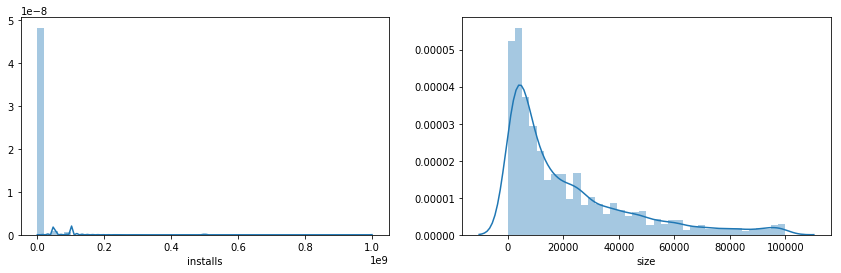

In [195]:
fig, axs = plt.subplots(nrows = 1,ncols = 2)
fig.subplots_adjust(right = 2)
sns.distplot(df['installs'], ax = axs[0])
sns.distplot(df['size'], ax = axs[1])

In [167]:
# split rating into two labels
Y = pd.cut(Y, 
           bins=[0, 4, 5], 
           labels=[0, 1])
Y.value_counts()
Y = Y.codes

0    132
1    295
dtype: int64

In [144]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

0.04158467326107429

/home/bob/programs/anaconda3/envs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


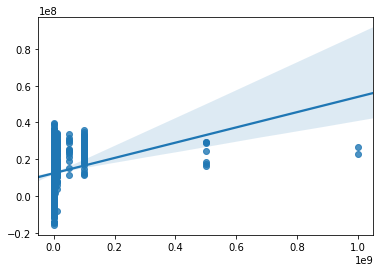

In [149]:
from sklearn.linear_model import Ridge
reg = Ridge()
reg.fit(x_train, y_train)
reg.score(x_train, y_train)
sns.regplot(y_train, reg.predict(x_train))

In [36]:
# the dataset is rather imbalanced, which will skew the results. So we reduce the number of big rating examples
# we can also try upsampling the small rating examples
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
# from imblearn.usampler import TODO
sampler = RandomOverSampler(random_state = 42)
x_train, y_train = sampler.fit_resample(x_train,y_train)
len(y_train[y_train==1])
len(y_train[y_train==0])

3922

3922

In [148]:
from sklearn import preprocessing
# scale data if needed. forests and trees don't need it. Others do. 
scale = True
if scale:
    scaler = preprocessing.StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [39]:
from sklearn import ensemble, tree, svm, neighbors
from sklearn.model_selection import cross_val_score
from model import Model, ModelsBenchmark

models = [
        svm.SVC(kernel = 'rbf', random_state=42),
        tree.DecisionTreeClassifier( min_impurity_decrease = 0, min_samples_leaf = 1, random_state = 42),
        ensemble.RandomForestClassifier(n_estimators=100, min_impurity_decrease=0, min_samples_leaf=1, random_state=42),
        neighbors.KNeighborsClassifier(n_neighbors = 2)
         ]
bench = ModelsBenchmark(models);
bench.fit(x_train, y_train);
bench.score(x_train, y_train);
bench.score(x_test, y_test);
bench._scores

[(0.9808771035186129,
  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=42,
              splitter='best')),
 (0.9808771035186129,
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
              oob_score=False, random_state=42, verbose=0, warm_start=False)),
 (0.8574706782253952,
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          

[(0.6511954992967651,
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
              oob_score=False, random_state=42, verbose=0, warm_start=False)),
 (0.6125175808720112,
  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=42,
              splitter='best')),
 (0.580168776371308, SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_ite

[(0.6511954992967651,
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
              oob_score=False, random_state=42, verbose=0, warm_start=False)),
 (0.6125175808720112,
  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=42,
              splitter='best')),
 (0.580168776371308, SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_ite

In [55]:
# hyperparameters will be tuned agains the following score mean. 
# This is called cross-validation and is done to avoid overfitting the test data
clf = ensemble.RandomForestClassifier(n_estimators=100, min_impurity_decrease=0, min_samples_leaf=1, random_state=42)
scores = cross_val_score(clf, x_train, y_train, cv = 3)
scores
scores.mean()
clf.fit(x_train,y_train)
clf.score(x_test,y_test)

array([0.76490826, 0.77735272, 0.81943382])

0.7872315969760569

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

0.6511954992967651

# Evaluating models

In [45]:
# reduce dimensionality to be able to plot data
from sklearn.decomposition import PCA

pca = PCA(n_components = 2, random_state = 42);
    
def reduce_dimensions(X, fit=False):
    if fit:
        pca.fit(X)
    return pca.transform(X)


[(0.6511954992967651,
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
              oob_score=False, random_state=42, verbose=0, warm_start=False)),
 (0.6125175808720112,
  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=42,
              splitter='best')),
 (0.580168776371308, SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_ite

Text(0.5, 1.0, 'Train Data')

Text(0.5, 0, 'x_0')

Text(0, 0.5, 'x_1')

Text(0.5, 1.0, 'Test Data')

Text(0.5, 0, 'x_0')

Text(0, 0.5, 'x_1')

Text(0.5, 1.0, 'Test')

Text(0.5, 15.0, 'Predicted')

Text(455.608695652174, 0.5, 'Actual')

Text(0.5, 1.0, 'Train')

Text(0.5, 15.0, 'Predicted')

Text(666.913043478261, 0.5, 'Actual')

[[3890   32]
 [ 118 3804]]
Train Accuracy : 0.98 
Test Accuracy : 0.65 


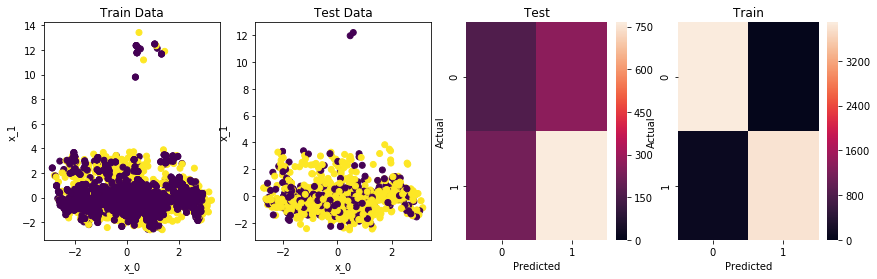

In [46]:
# print and plot metrics for the best one
from sklearn.metrics import confusion_matrix
bench.fit(x_train, y_train)
bench.score(x_test, y_test)
clf = bench._sorted[0]
fig, axs = plt.subplots(nrows = 1, ncols = 4);
fig.subplots_adjust(right = 2);
x_plot = reduce_dimensions(x_train, fit = True)
axs[0].scatter(x_plot[:, 0], x_plot[:,1], c = y_train);
axs[0].set_title('Train Data');
axs[0].set_xlabel('x_0');
axs[0].set_ylabel('x_1');
x_plot = reduce_dimensions(x_test)
axs[1].scatter(x_plot[:, 0], x_plot[:,1], c = y_test);
axs[1].set_title('Test Data');
axs[1].set_xlabel('x_0');
axs[1].set_ylabel('x_1');
test_cnf_matrix = confusion_matrix(y_test, clf.predict(x_test))
sns.heatmap(test_cnf_matrix, ax = axs[2], vmin = 0);
axs[2].set_title('Test');
axs[2].set_xlabel('Predicted');
axs[2].set_ylabel('Actual');
train_cnf_matrix = confusion_matrix(y_train, clf.predict(x_train))
sns.heatmap(train_cnf_matrix, ax = axs[3], vmin = 0);
axs[3].set_title('Train');
axs[3].set_xlabel('Predicted');
axs[3].set_ylabel('Actual');
print(train_cnf_matrix)
print('Train Accuracy : %.2f ' % clf.score(x_train, y_train))
print('Test Accuracy : %.2f ' % clf.score(x_test, y_test))

In [65]:
clf = ensemble.RandomForestClassifier(n_estimators=100, min_impurity_decrease=0, min_samples_leaf=1, random_state=42)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

Text(0.5, 1.0, 'Points with true label 0 ')

/home/bob/programs/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  app.launch_new_instance()


AttributeError: 'bool' object has no attribute 'sum'

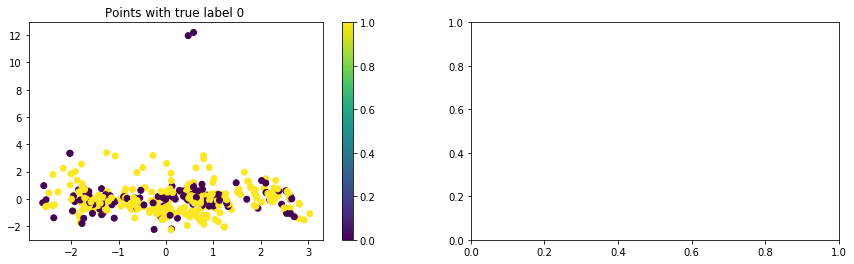

In [67]:
# plot both labels separately and our predictions on them
fig, axs = plt.subplots(nrows = 1, ncols = 2)
x_plot_train = reduce_dimensions(x_train, fit=True)
y_plot_train = y_train
x_plot_test = reduce_dimensions(x_test)
y_plot_test = y_test
clf.fit(x_plot_train,y_plot_train)
x_plot = x_plot_test
y_plot = y_plot_test
y_pred = clf.predict(x_plot)
fig.subplots_adjust(right = 2)
labeled_0 = x_plot[y_plot == 0]
scatter = axs[0].scatter(labeled_0[:,0], labeled_0[:, 1], c = y_pred[y_plot ==  0], )
fig.colorbar(scatter, ax = axs[0])
axs[0].set_title('Points with true label 0 ')
labeled_0_acc = (y_pred == 0) == (y_plot == 0).sum() / len(y_pred)
print('Accuracy for true label 0 : %.3f' % labeled_0_acc)
labeled_1 = x_plot[y_plot == 1]
scatter = axs[1].scatter(labeled_1[:,0], labeled_1[:, 1], c = y_pred[y_plot == 1] )
fig.colorbar(scatter, ax = axs[1])
axs[1].set_title('Points with true label 1 ')

In [73]:
y_pred == 0

array([ True,  True, False, ..., False, False,  True])

In [57]:
# print some correctly and incorrectly labeled data
from random import randint
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
# correct = x_test[y_pred == y_test]
# incorrect = x_test[~(y_pred == y_test)]

columns = df.columns.values
def get_samples(x, y_true, y_pred, sample_type = 'correct', count = 5):
    mask = (y_pred == y_true)
    if sample_type == 'incorrect':
        mask = ~mask
    x = x[mask]
    y_pred = y_pred[mask]
    y_true = y_true[mask]
    df = pd.DataFrame(columns=[*columns , 'predicted', 'true'])
    if len(x) == 0:
        return df
    for _ in range(count):
        idx = randint(0, len(x)) 
        dct = {}
        dct['predicted'] = y_pred[idx]
        dct['true'] = y_true[idx]
        for i in range(x.shape[1]):
            dct[df.columns.values[i]] = x[idx][i]
        df = df.append(dct,
                       ignore_index=True)
    return df

print("====Correct samples =====")
get_samples(x_test, y_test, y_pred, sample_type='correct') 
print("====Incorrect samples =====")
get_samples(x_test, y_test, y_pred, sample_type='incorrect') 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

====Correct samples =====


,category,rating,reviews,size,installs,type,price,content_rating,genres,version,android_version,price_rounded,last_updated_days,last_updated_year,last_updated_day,last_updated_month_sin,last_updated_month_cos,name_wc,predicted,true
0,1.534440,0.256275,3.575694,0.063980,-0.411854,1.463326,0.345649,1.289994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
1,0.705362,-0.682584,-0.279666,-0.071708,-0.411854,0.025876,0.345649,-0.358542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
2,0.981721,2.025141,-0.279666,-0.071708,-0.411854,1.175836,0.345649,-0.908054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,0.981721,-0.916437,3.575694,0.154741,-0.411854,1.175836,-2.796031,0.190970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,0.981721,-0.637228,-0.279666,-0.071708,-0.411854,1.175836,0.345649,0.190970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0


====Incorrect samples =====


,category,rating,reviews,size,installs,type,price,content_rating,genres,version,android_version,price_rounded,last_updated_days,last_updated_year,last_updated_day,last_updated_month_sin,last_updated_month_cos,name_wc,predicted,true
0,0.567182,-0.519304,-0.279666,-0.071708,-0.411854,1.032091,-1.748805,0.190970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
1,0.152643,-0.818650,-0.279666,-0.071708,-0.411854,0.816473,0.345649,-0.908054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
2,0.014463,0.845897,-0.279666,-0.071708,0.930308,-1.124085,0.345649,-0.358542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
3,-2.196414,-0.823186,-0.279666,-0.071708,-0.411854,-1.555320,-1.748805,-0.908054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
4,-0.814616,0.256275,-0.279666,-0.071708,-0.411854,-0.836595,1.392876,-0.358542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0


(0.6152473227944926, 0.5745428973277075)

5

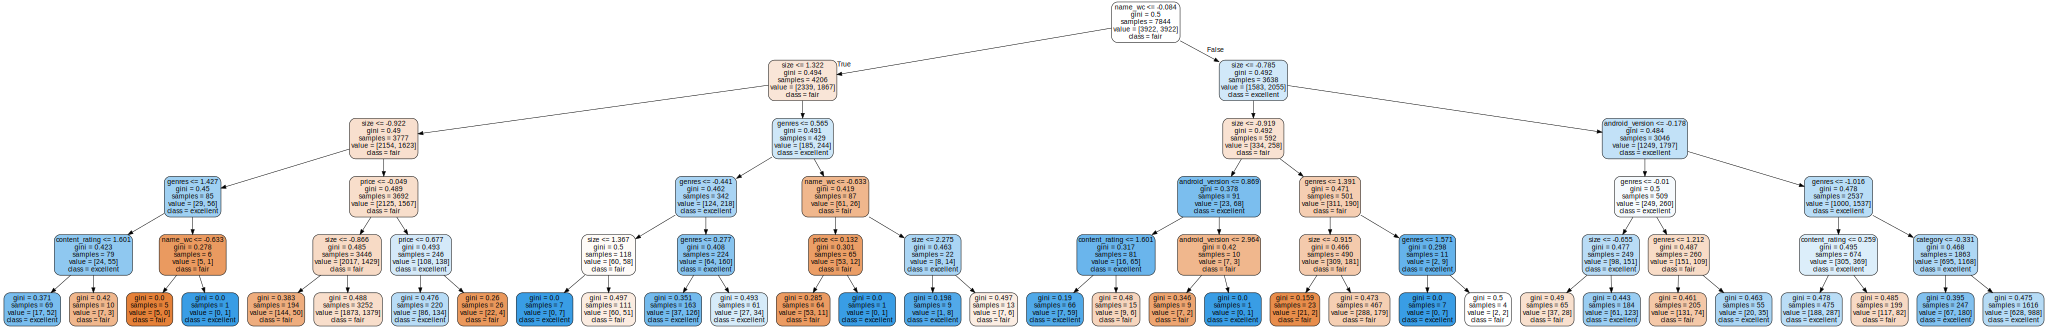

In [62]:
# Visualisation of the decision tree created by the algorithm, for fun and insight
import graphviz
from sklearn.tree import export_graphviz
clf = Model(tree.DecisionTreeClassifier(max_depth = 5))
clf.compute_scores((x_train, y_train), (x_test, y_test))
clf.model.tree_.max_depth
dot_data = export_graphviz(clf.model,
                           out_file=None,
                           feature_names=pre_features,
                           class_names=['fair', 'excellent'],
                           filled=True,
                           rounded=True)
graph = graphviz.Source(dot_data)
graph

# Neural network model

In [188]:
import keras
from keras import layers

num_classes = 2
input_shape = x_train.shape[1]
model = keras.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(input_shape,)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation='relu'))
# model.add(layers.BatchNormalization(input_shape=(input_shape,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 512)               4608      
_________________________________________________________________
batch_normalization_14 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_56 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_57 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_87 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_58 (Dropout)         (None, 512)               0         
__________

In [189]:
model.compile(loss='categorical_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy'])

In [190]:
from keras.utils import to_categorical
no_epochs = 20
batch_size = 1024
history = model.fit(x_train, to_categorical(y_train), batch_size = batch_size, epochs = no_epochs )

Epoch 1/20
7844/7844 [==============================] - 3s 346us/step - loss: 1.3516 - acc: 0.5032
Epoch 2/20
7844/7844 [==============================] - 1s 107us/step - loss: 0.7105 - acc: 0.5105
Epoch 3/20
7844/7844 [==============================] - 1s 109us/step - loss: 0.7088 - acc: 0.5145
Epoch 4/20
7844/7844 [==============================] - 1s 111us/step - loss: 0.6944 - acc: 0.5310
Epoch 5/20
7844/7844 [==============================] - 1s 110us/step - loss: 0.6989 - acc: 0.5158
Epoch 6/20
7844/7844 [==============================] - 1s 110us/step - loss: 0.7008 - acc: 0.5162
Epoch 7/20
7844/7844 [==============================] - 1s 109us/step - loss: 0.7014 - acc: 0.5213
Epoch 8/20
7844/7844 [==============================] - 1s 110us/step - loss: 0.6948 - acc: 0.5287
Epoch 9/20
7844/7844 [==============================] - 1s 111us/step - loss: 0.6936 - acc: 0.5205
Epoch 10/20
7844/7844 [==============================] - 1s 111us/step - loss: 0.6966 - acc: 0.5255
Epoch 11/

In [171]:
model.evaluate(x_test, to_categorical(y_test))

1422/1422 [==============================] - 2s 2ms/step


[0.7050470376148841, 0.4592123771853923]

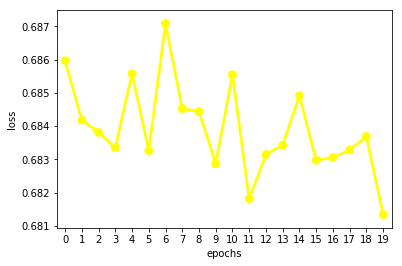

In [186]:
df = pd.DataFrame({'epochs':history.epoch, 'loss': history.history['loss'], 
#                    'validation_loss': history.history['val_loss']
                  })
g = sns.pointplot(x="epochs", y="loss", data=df, fit_reg=False, color = 'yellow')
# g = sns.pointplot(x="epochs", y="validation_loss", data=df, fit_reg=False, color='red')

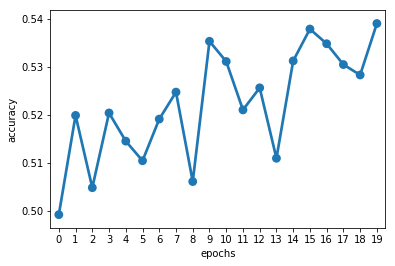

In [172]:
import seaborn as sns
df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc']
#                    , 'validation_accuracy': history.history['val_acc']
                  })
g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
# g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')